# Note: Abandoned this current approach because it is based on a univariate data approach. This means that it is applied when the only information we have about the curve is the past values of the curve itself. It doesnt give us much insight into multiple features being associated.

# Time Series Forecasting Tutorial using PyTorch 
Found some bugs and corrected them. The dataset seems to have been updated since the author posted their tutorial

In [ ]:
# https://www.geeksforgeeks.org/data-analysis/time-series-forecasting-using-pytorch/

## Time Series Forecasting

Time series is a set of observations at regular periods of time. It tries to estimate future values from current patterns and treands. Traditional approaches include ARIMA, but they have trouble with long-term dependencies in data. LSTMs excel at capturing these. 

## Dataset
In this tutorial, we use the Yahoo Finance dataset with the following:

In [1]:
!pip install yfinance

## Step 1: Import libraries and set the configuration

In [17]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, r2_score
from collections import defaultdict

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

Colour_Palette = ['#01BEFE', '#FF7D00', '#FFDD00', '#FF006D', '#ADFF02', '#8F00FF']
sns.set_palette(sns.color_palette(Colour_Palette))

tqdm.pandas()

## Step 2: Load and Inspect Data
Download the historical stock price data for Apple (AAPL) from the Yahoo finance datasets. Inspect the data with <code>df.head()</code> and <code>df.info()</code> to understand structure and contents. 

In [2]:
import yfinance as yf
from datetime import date

# end_date = date.today().strftime("%Y-%m-%d")
end_date = '2024-08-22' # changed to end date of tutorial
start_date = '1990-01-01'

df = yf.download('AAPL', start=start_date, end=end_date)

/var/folders/jm/d49dqhd91j9g3f2wf9zhq0z80000gn/T/ipykernel_61787/772535922.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AAPL', start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


In [3]:
# Inspect the data
print(df.head())
print(df.info())

Price          Close      High       Low      Open     Volume
Ticker          AAPL      AAPL      AAPL      AAPL       AAPL
Date                                                         
1990-01-02  0.261499  0.263254  0.245704  0.247458  183198400
1990-01-03  0.263253  0.266764  0.263253  0.266764  207995200
1990-01-04  0.264132  0.272029  0.261498  0.268519  221513600
1990-01-05  0.265009  0.268519  0.259744  0.265009  123312000
1990-01-08  0.266764  0.266764  0.259744  0.263254  101572800
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8726 entries, 1990-01-02 to 2024-08-21
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   8726 non-null   float64
 1   (High, AAPL)    8726 non-null   float64
 2   (Low, AAPL)     8726 non-null   float64
 3   (Open, AAPL)    8726 non-null   float64
 4   (Volume, AAPL)  8726 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 409.0 KB
None


Note: It seems like the way the data is structured has changed since the user created this tutorial. For example, now there are multiple axis: Price and Ticker. This will be fixed below. Additionally, two columns appear to stop existing. Now we only have: Close, High, Low, Open, Volume - but not Close Adj.  

In [10]:
df

Price,Close,High,Low,Open,Volume
Date,,,,,
1990-01-02,0.261499,0.263254,0.245704,0.247458,183198400
1990-01-03,0.263253,0.266764,0.263253,0.266764,207995200
1990-01-04,0.264132,0.272029,0.261498,0.268519,221513600
1990-01-05,0.265009,0.268519,0.259744,0.265009,123312000
1990-01-08,0.266764,0.266764,0.259744,0.263254,101572800
...,...,...,...,...,...
2024-08-15,223.932846,224.560644,221.979705,223.813271,46414000
2024-08-16,225.258194,226.035461,222.866592,223.135650,44340200
2024-08-19,225.098755,225.198411,222.258732,224.929352,40687800


In [11]:
df.describe()

Price,Close,High,Low,Open,Volume
count,8726.000000,8726.000000,8726.000000,8726.000000,8.726000e+03
mean,27.355737,27.632265,27.054922,27.336139,3.588067e+08
std,50.154249,50.652217,49.608180,50.108641,3.587390e+08
min,0.097206,0.099555,0.095797,0.096737,2.396800e+06
25%,0.315569,0.321622,0.308055,0.315705,1.276736e+08
50%,2.708633,2.756270,2.664755,2.705628,2.404808e+08
75%,25.526175,25.739630,25.249481,25.459619,4.540144e+08
max,233.726929,236.125712,232.004984,235.379203,7.421641e+09


In [12]:
df.columns

Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')

In [8]:
df.columns = df.columns.droplevel('Ticker')

In [9]:
df.describe()

Price,Close,High,Low,Open,Volume
count,8726.000000,8726.000000,8726.000000,8726.000000,8.726000e+03
mean,27.355737,27.632265,27.054922,27.336139,3.588067e+08
std,50.154249,50.652217,49.608180,50.108641,3.587390e+08
min,0.097206,0.099555,0.095797,0.096737,2.396800e+06
25%,0.315569,0.321622,0.308055,0.315705,1.276736e+08
50%,2.708633,2.756270,2.664755,2.705628,2.404808e+08
75%,25.526175,25.739630,25.249481,25.459619,4.540144e+08
max,233.726929,236.125712,232.004984,235.379203,7.421641e+09


In [13]:
print(df.head())
print(df.info())

Price          Close      High       Low      Open     Volume
Date                                                         
1990-01-02  0.261499  0.263254  0.245704  0.247458  183198400
1990-01-03  0.263253  0.266764  0.263253  0.266764  207995200
1990-01-04  0.264132  0.272029  0.261498  0.268519  221513600
1990-01-05  0.265009  0.268519  0.259744  0.265009  123312000
1990-01-08  0.266764  0.266764  0.259744  0.263254  101572800
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8726 entries, 1990-01-02 to 2024-08-21
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   8726 non-null   float64
 1   High    8726 non-null   float64
 2   Low     8726 non-null   float64
 3   Open    8726 non-null   float64
 4   Volume  8726 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 409.0 KB
None


In [14]:
df.Open

Date
1990-01-02      0.247458
1990-01-03      0.266764
1990-01-04      0.268519
1990-01-05      0.265009
1990-01-08      0.263254
                 ...    
2024-08-15    223.813271
2024-08-16    223.135650
2024-08-19    224.929352
2024-08-20    224.979185
2024-08-21    225.726539
Name: Open, Length: 8726, dtype: float64

## Step 3: Plot Data
Define a dunction to plot the data using line plots for each column in the DataFrame. This will help us visualize the trends and patterns in the data. 

In [15]:
df.shape

(8726, 5)

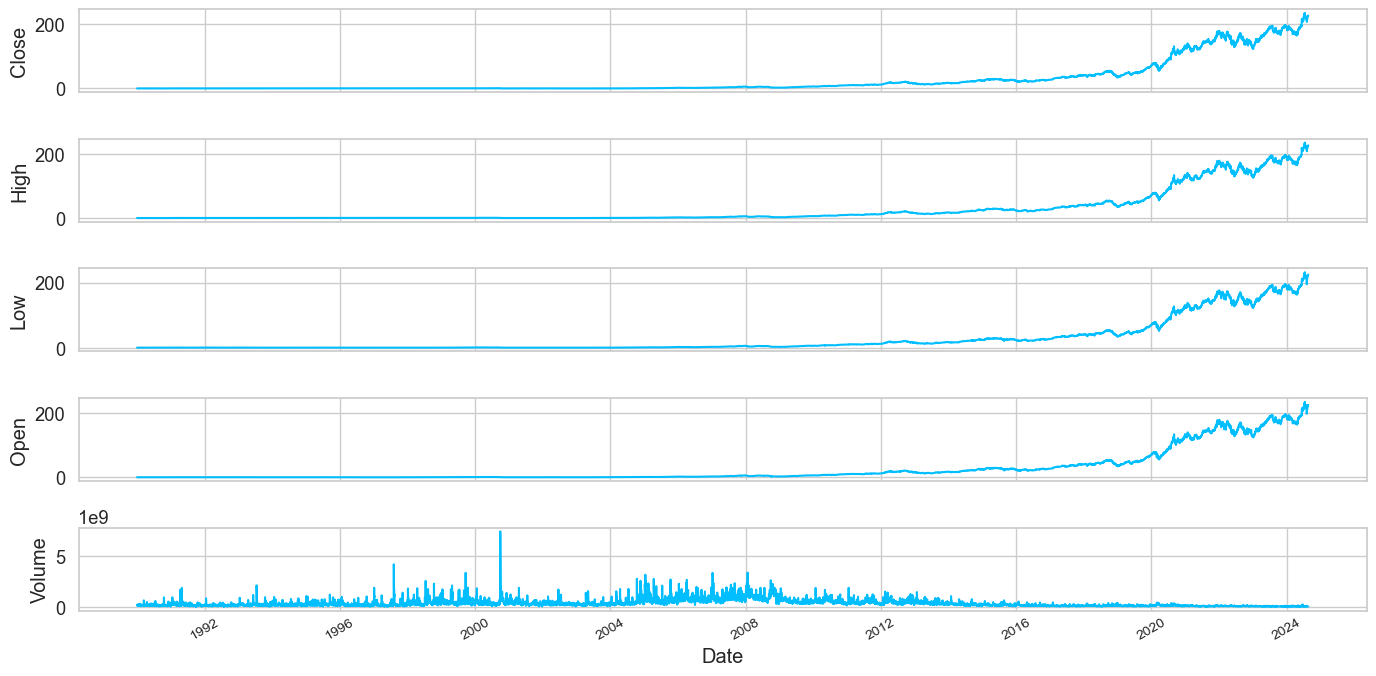

In [19]:
import matplotlib.dates as mdates

def data_plot(df):
    # Plot line charts
    df_plot = df.copy()

    ncols = 1
    nrows = int(round(df_plot.shape[1] / ncols, 0))

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
    for i, ax in enumerate(fig.axes):
        sns.lineplot(data=df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    fig.tight_layout()
    plt.show()

# Plot the data
data_plot(df)

In [20]:
df.Open

Date
1990-01-02      0.247458
1990-01-03      0.266764
1990-01-04      0.268519
1990-01-05      0.265009
1990-01-08      0.263254
                 ...    
2024-08-15    223.813271
2024-08-16    223.135650
2024-08-19    224.929352
2024-08-20    224.979185
2024-08-21    225.726539
Name: Open, Length: 8726, dtype: float64

## Step 4: Preprocess Data 
* Split the data into training and testing sets 
* Normalize the values wtih the MinMaxScaler 

* <code>math.ceil</code> is used to calculate the number of training data points 
* <code> train_data </code> and <code> test_data </code> are used to split the DF into training and testing sets 
* <code> MinMaxScaler </code> scales the data to fit in the range of [0,1]. This enables the NN to converge faster

In [21]:
import math
from sklearn.preprocessing import MinMaxScaler

# Train test split
training_data_len = math.ceil(len(df) * .8)
print(training_data_len)

6981


In [29]:
# Splitting the dataset
train_data = df[:training_data_len].iloc[:, :]
test_data = df[training_data_len:].iloc[:, :]
print(train_data.shape, test_data.shape)

# in the tutorial they only select the Open category to train on

(6981, 5) (1745, 5)


In [32]:
# Selecting Open Price values
dataset_train = train_data.Open.values
# Reshaping 1D to 2D array
dataset_train = np.reshape(dataset_train, (-1, 1))
print(dataset_train.shape)

(6981, 1)


In [33]:
# Selecting Open Price values
dataset_test = test_data.Open.values
# Reshaping 1D to 2D array
dataset_test = np.reshape(dataset_test, (-1, 1))
print(dataset_test.shape)

(1745, 1)


In [34]:
scaler = MinMaxScaler(feature_range=(0, 1))
# Scaling dataset
scaled_train = scaler.fit_transform(dataset_train)
print(scaled_train[:5])

# Normalizing values between 0 and 1
scaled_test = scaler.fit_transform(dataset_test)
print(scaled_test[:5])

[[0.00392088]
 [0.0044231 ]
 [0.00446875]
 [0.00437745]
 [0.00433177]]
[[0.01433089]
 [0.01372611]
 [0.01563332]
 [0.01493552]
 [0.0130632 ]]


## Step 5: Create Sequences and Labels for Training and Testing

We structure the data into sequences for the LSTM model. Each sequence contains a number of time steps in it. We then convert the data into PyTorch tensors - necessary for input into the model. 

* <code>sequence_length</code> is the number of time steps the model looks back to make the next prediction
* <code>X_train and y_train</code> are the arrays holding the input sequences and their corresponding labels for training
* <code>X_test and y_test </code> arrays for testing the data
* <code>torch.tensor</code> converts the numpy arrays into PyTorch tensors

In [ ]:
# Create sequences and labels for training data

sequence_length = 50  # Number of time steps to look back
X_train, y_train = [], []

for i in range(len(scaled_train) - sequence_length):
    X_train.append(scaled_train[i:i + sequence_length])
    y_train.append(scaled_train[i + sequence_length])  # Predicting the value right after the sequence
X_train, y_train = np.array(X_train), np.array(y_train)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
print(X_train.shape, y_train.shape)

sequence_length = 50

# Create sequences and labels for testing data
X_test, y_test = [], []
for i in range(len(scaled_test) - sequence_length):
    X_test.append(scaled_test[i:i + sequence_length])
    y_test.append(scaled_test[i + sequence_length])  # Predicting the value right after the sequence
X_test, y_test = np.array(X_test), np.array(y_test)

# Convert data to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
print(X_test.shape, y_test.shape)

torch.Size([6931, 50, 1]) torch.Size([6931, 1])
torch.Size([1695, 50, 1]) torch.Size([1695, 1])


## Step 6: Define and Train the LSTM Model

Define the LSTM model for time series forecasting. The model includes an LSTM layer followed by a fully connected layer. TRain the model using the training data and evaluate it on the test data. 

* <code> LSTMModel </code> is PyTorch's neural network class with an LSTM layer and a linear layer
* <code> Device Configuration </code> checks if a GPU is available to use if possible
* <code> Hyperparameters </code> Settings like input size, hidden size, no of layers, dropout rate, batch size, learning rate, and number of epochs 
* <code> DataLoader </code> Utility to handle batching and shuffling of the dataset
* <code> Training Loop </code> loops over the dataset for a specified number of epochs performing forward and backward passes and updating the model weights

In [36]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.linear(out[:, -1, :])
        return out

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

input_size = 1
num_layers = 2  # Increased number of layers
hidden_size = 4  # Increased number of hidden units
output_size = 1
dropout = 0.2  # Added dropout for regularization

model = LSTMModel(input_size, hidden_size, num_layers, dropout).to(device)
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Learning rate

batch_size = 32  # Adjusted batch size
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_epochs = 10  
train_hist = []
test_hist = []

for epoch in range(num_epochs):
    total_loss = 0.0
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)

    model.eval()
    with torch.no_grad():
        total_test_loss = 0.0

        for batch_X_test, batch_y_test in test_loader:
            batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
            predictions_test = model(batch_X_test)
            test_loss = loss_fn(predictions_test, batch_y_test)

            total_test_loss += test_loss.item()

        average_test_loss = total_test_loss / len(test_loader)
        test_hist.append(average_test_loss)

    if (epoch + 1) % 2 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')

cpu
Epoch [2/10] - Training Loss: 0.0142, Test Loss: 0.0042
Epoch [4/10] - Training Loss: 0.0006, Test Loss: 0.0010
Epoch [6/10] - Training Loss: 0.0005, Test Loss: 0.0009
Epoch [8/10] - Training Loss: 0.0004, Test Loss: 0.0009
Epoch [10/10] - Training Loss: 0.0003, Test Loss: 0.0008


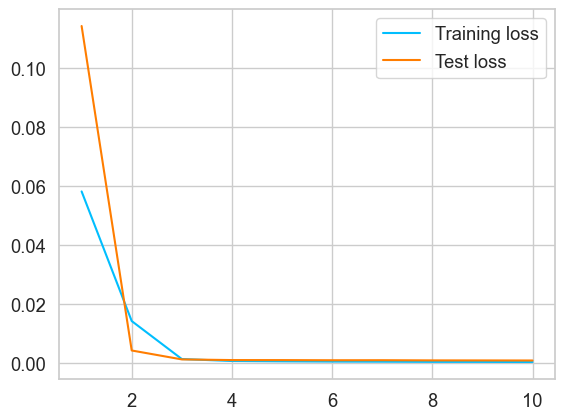

In [37]:
x = np.linspace(1,num_epochs,num_epochs)
plt.plot(x,train_hist,scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.show()

## Step 7: Forecast Future Values and Evaluate the Model 

Use the trained model to forecast future values. Evaluate the model's performance using metrics like RMSE and R2 score. 

* <code> Forecasting </code> generates future values using the trained model
* <code> Plotting </code> visualizes the actual and forecasted values
* <code> Evaluation </code> Calculates the RMSE and R2 score to evaluate the model's performance

In [38]:
num_forecast_steps = 30
sequence_to_plot = X_test.squeeze().cpu().numpy()
historical_data = sequence_to_plot[-1]

In [41]:
sequence_to_plot[-1].shape

(50,)

In [42]:
forecasted_values = []
with torch.no_grad():
    for _ in range(num_forecast_steps):
        historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(device)
        predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]
        forecasted_values.append(predicted_value)
        historical_data = np.roll(historical_data, shift=-1)
        historical_data[-1] = predicted_value

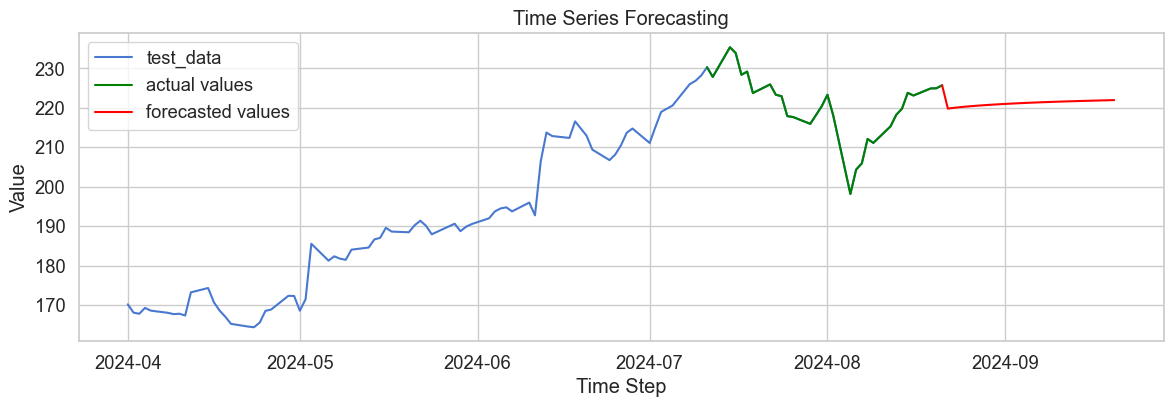

RMSE: 0.0286
R² Score: 0.9891


In [43]:
last_date = test_data.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=30)

plt.rcParams['figure.figsize'] = [14, 4]
plt.plot(test_data.index[-100:], test_data.Open[-100:], label="test_data", color="b")
plt.plot(test_data.index[-30:], test_data.Open[-30:], label='actual values', color='green')
plt.plot(test_data.index[-1:].append(future_dates), np.concatenate([test_data.Open[-1:], scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1)).flatten()]), label='forecasted values', color='red')

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.title('Time Series Forecasting')
plt.grid(True)
plt.show()

# Evaluate the model and calculate RMSE and R² score
model.eval()
with torch.no_grad():
    test_predictions = []
    for batch_X_test in X_test:
        batch_X_test = batch_X_test.to(device).unsqueeze(0)  # Add batch dimension
        test_predictions.append(model(batch_X_test).cpu().numpy().flatten()[0])

test_predictions = np.array(test_predictions)

# Calculate RMSE and R² score
rmse = np.sqrt(mean_squared_error(y_test.cpu().numpy(), test_predictions))
r2 = r2_score(y_test.cpu().numpy(), test_predictions)

print(f'RMSE: {rmse:.4f}')
print(f'R² Score: {r2:.4f}')